In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

#### Load data:

In [2]:
dat = "GZZ_data2.jld"
X = load(dat, "X")
y = load(dat, "y")
ξ_true = load(dat, "xi_true");

d, Nobs = size(X)
mb_size = Int(round(Nobs/2))

100

#### Define prior:

In [19]:
σ02 = 1
prior = NG_prior(d, σ02)
prior.λ_scale = 0.01
prior.λ_attempts = 200

200

#### Define model:

In [20]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

#### Define minibatch sampler:

In [21]:
# Sub-Sampling without control variate and with weights
ϵ = 1e-2
weights = abs.(X) + ϵ
weights ./= sum(weights,2)
gs = [wumbsampler(Nobs, mb_size, weights[i,:]) for i in 1:d]
gs_list = mbsampler_list(d,gs);

#### Define outputscheduler:

In [22]:
A = eye(d)

opf = projopf(A, 100, hyperparam_size(prior))
opt = maxa_opt(10^7)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

#### Define mbsampler + block Gibbs sampler list:

In [23]:
adapt_speed = false
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [24]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

10% attempts in 11.6 mins 
20% attempts in 22.98 mins 
30% attempts in 34.22 mins 
40% attempts in 45.22 mins 
50% attempts in 55.62 mins 
60% attempts in 66.48 mins 
70% attempts in 77.34 mins 
80% attempts in 88.48 mins 
90% attempts in 100.27 mins 
100% attempts in 111.51 mins 
111.51 mins

In [25]:
zz_bounces = sum(zz_state(outp.opf).n_bounces)
hyp_bounces = outp.opf.tcounter-sum(zz_state(outp.opf).n_bounces)
@printf("ZZ bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ bounces: 65975, hyper bounces: 5004

In [26]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts

0.0070979

#### Extract samples:

In [27]:
discard = 0
n_samples = 10^4-1
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear")[:,1:end-1];
hyp_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[end]/n_samples,
                              "constant")[:,1:end-1];

#### Plot ACFs:

In [28]:
maxlag = 200
acfs_xi = zeros(d, maxlag)
acfs_hyp = zeros(size(hyp_samples,1), maxlag)

for i in 1:d 
    acfs_xi[i,:] = acf(xi_samples[i,:], maxlag)
end
for i in 1:size(hyp_samples,1)
    acfs_hyp[i,:] = acf(hyp_samples[i,:], maxlag)
end

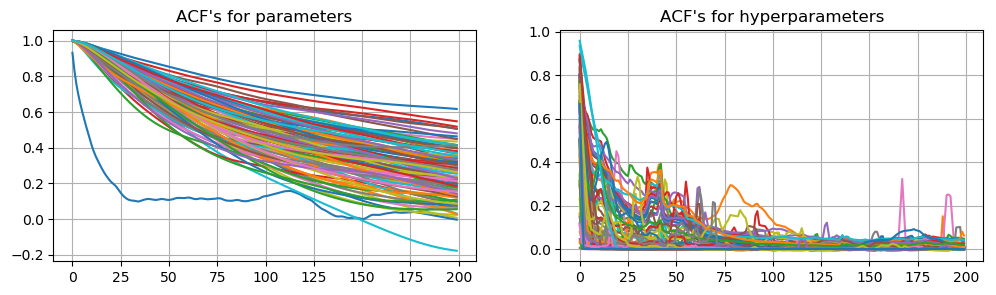

In [29]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
for i in 1:d 
    plot(acfs_xi[i,:])
end
grid(true)
title("ACF's for parameters")

subplot(122)
for i in 1:size(hyp_samples,1) 
    plot(acfs_hyp[i,:])
end
grid(true)
title("ACF's for hyperparameters");

#### Posterior coverage:

In [30]:
cover = zeros(d)
ci = zeros(d,2)
for i in 1:d 
    ci[i,:] = percentile(xi_samples[i,:], [5, 95])
    cover[i] = (ci[i,1]<ξ_true[i])&(ξ_true[i]<ci[i,2])
end

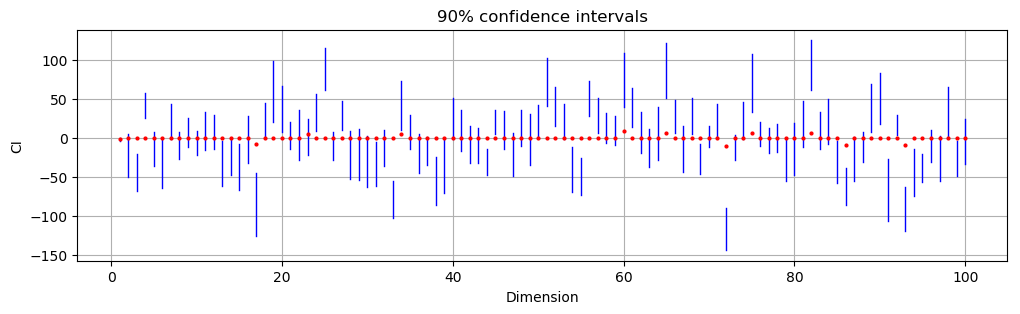

In [31]:
fig = figure("pyplot_barplot",figsize=(12,3))
for i in 1:d 
    plot([i,i], ci[i,:], color="blue", linewidth=1)
end
plot(1:d , ξ_true, "o", markersize=4, color="red", markersize=2)
grid(true)
xlabel("Dimension")
ylabel("CI")
title("90% confidence intervals");